In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from astropy.visualization import hist

import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

## Part 1: Visualizing patterns in the data

In this exercise, I will generate the visualizations described below. For each set of plots, I will describe the plots. I will select these crimes to summarize the main problem of the city.

In [3]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

### Weekly patterns

In [3]:
data = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

In [4]:
data['Date'] = pd.to_datetime(data['Date']) # change date column to datetime object
data['Time'] = pd.to_datetime(data['Time']) # change date column to datetime object

data['Weekday'] = data['Date'].dt.dayofweek # new columns with weekdays from 0-6
data['Hour'] = data['Time'].dt.hour # new columns with hours 0-168

In [5]:
focus_df = data[data['Category'].isin(focuscrimes)] # create a dataframe with focus categories

In [6]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

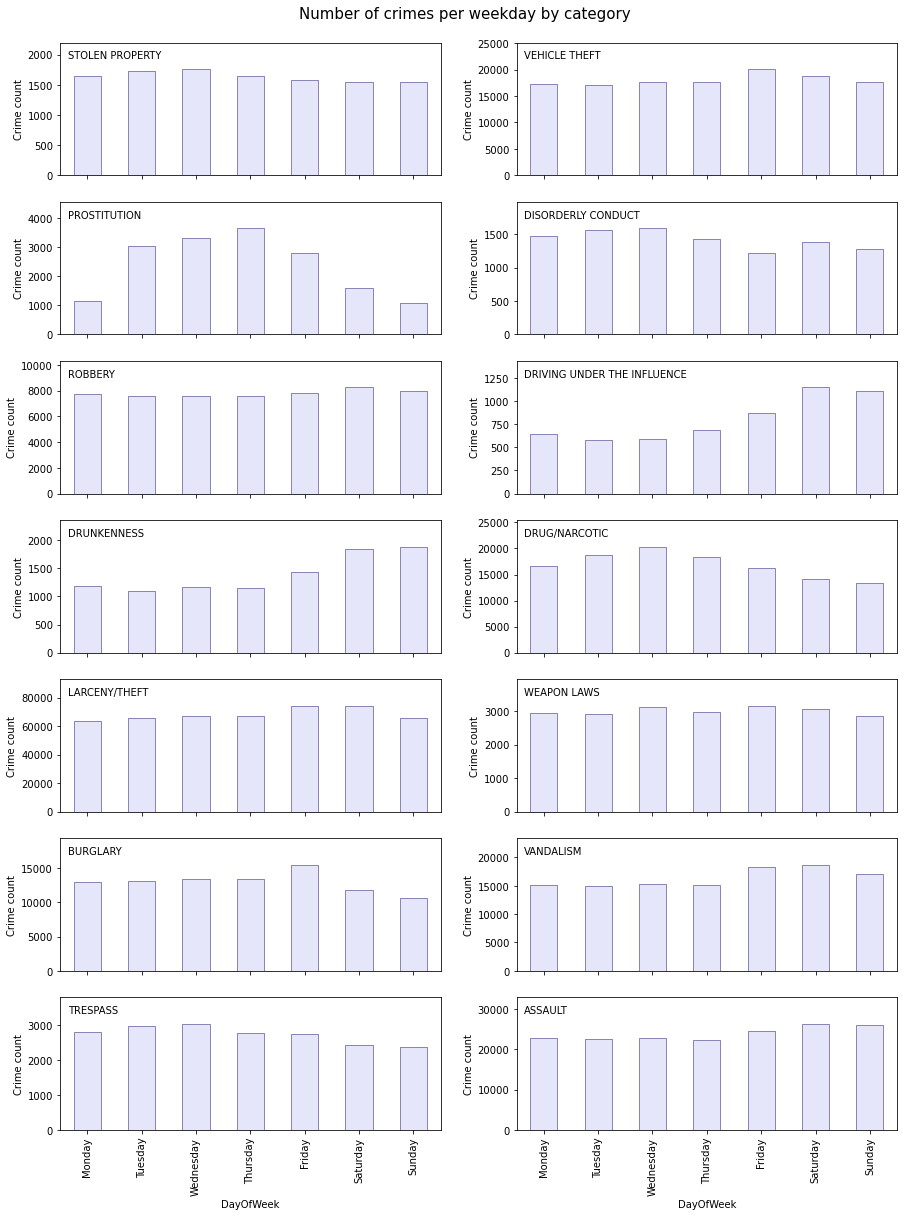

In [7]:
# plot the number of crimes per weekday by category
nrows = int(len(focuscrimes)/2)
ncol = 2
fig, axes = plt.subplots(nrows, ncol, sharex=True,  figsize =(15,20))
        
count = 0
for row in range(nrows):
    for col in range(ncol):
        category = list(focuscrimes)[count]
        focus_df_groupby = focus_df.sort_values(['Weekday'],ascending=False).\
                    groupby(['Category', 'Weekday', 'DayOfWeek']).count()['PdId']
        ax = focus_df_groupby[category].\
                    plot(ax = axes[row, col], kind='bar', color='lavender',
                    edgecolor='darkslateblue', linewidth=0.6)

        ax.axes.xaxis.set_ticklabels([])
        ax.set_xlabel('DayOfWeek')
        ax.set_ylabel('Crime count')
        ax.axes.xaxis.set_ticklabels(day_order)
        
        max_range = focus_df_groupby[category].max()
        ax.set_ylim([0, max_range+max_range/4])
        ax.text(0.02,0.88, category, transform=ax.transAxes)
        count += 1
        
fig.text(0.5, 0.9, 'Number of crimes per weekday by category', ha='center', va='center', fontsize=15);

The plot shows how many crimes occur every day of the week for each focus category. There are some interesting aspects to notice on these figures. For example, drunkness and driving under the influence happen more often during the weekends, which is to be expected. However, prostitution and drug/narcotic seem to happen more currently during the weekdays, especially on Wednesdays and Thursdays, and unexpectedly low during the weekends (Saturday and Sunday).

A possible cause of this could be that people using drugs are more likely to do that throughout the week and the people using alcohol are probably using significantly more during the weekend. Therefore, the police might be too busy on the weekends to handle both errands while on the weekdays they could pay more attention to drug-related crimes.

### Hours of the week

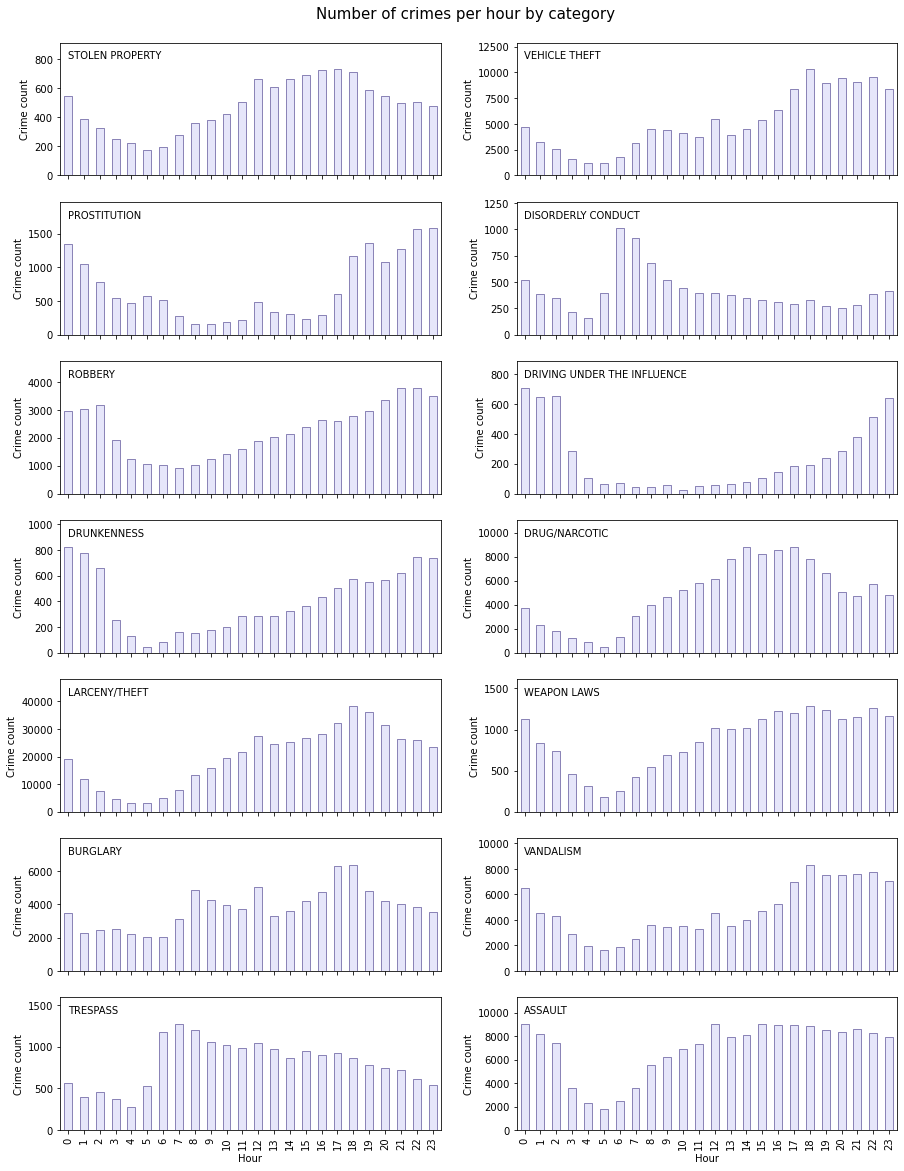

In [8]:
# plot the number of crimes per hour by category
nrows = int(len(focuscrimes)/2)
ncol = 2
fig, axes = plt.subplots(nrows, ncol, sharex=True,  figsize =(15,20))

count = 0
for row in range(nrows):
    for col in range(ncol):
        category = list(focuscrimes)[count]
        focus_df_groupby = focus_df.groupby(['Category', 'Hour']).count()['PdId']
        ax = focus_df_groupby[category].\
                plot(ax = axes[row, col], kind='bar', color='lavender',
                edgecolor='darkslateblue', linewidth=0.6)
        ax.set_ylabel('Crime count')
        
        max_range = focus_df_groupby[category].max()
        ax.set_ylim([0, max_range+max_range/4])
        ax.text(0.02,0.88, category, transform=ax.transAxes)
        
        count += 1
        
fig.text(0.5, 0.9, 'Number of crimes per hour by category', ha='center', va='center', fontsize=15);

The plots above show the number of crimes happening every hour of the day for each focus category. Again, there are a couple of things that are worth noticing in the figures. It is clear that drunkness and driving under the influence happen most frequently around midnight. One rather surprising aspect is that disorderly conduct seems to be occurring the most very early in the morning rather than later in the day.

### Spatial patterns

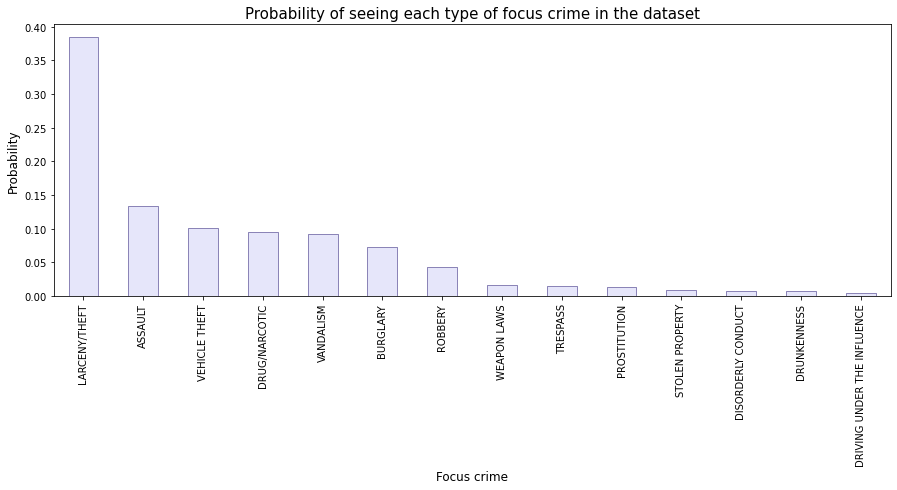

In [9]:
# P(crime), probabilities of seeing each type of crime in the dataset
p_crime_focus = focus_df['Category'].value_counts().div(len(focus_df))
p_crime_focus.plot(kind='bar', figsize=(15,5), color='lavender', edgecolor='darkslateblue', linewidth=0.6);
plt.title("Probability of seeing each type of focus crime in the dataset", fontsize=15);
plt.xlabel('Focus crime', fontsize=12)
plt.ylabel('Probability', fontsize=12);

To be able to calculate the ratio $\frac{P(crime|district)}{P(crime)}$, we first need to know the probability of each crime occurring $P(crime)$. The figure above shows which crimes are most likely to happen within the dataset. From this we see that larceny/theft is the crime that is most likely to occur.

Then we calculate the probability of each crime happening given the district $P(crime|district) = \frac{P(crime,district)}{P(district)}$. 

In [10]:
# P(district), probabilities of seeing each type of district in the dataset
p_dist_focus = focus_df['PdDistrict'].value_counts().div(len(focus_df))

# P(crime|district)=P(crime,district)/P(crime), probability of each crime happening given the district
p_crime_dist_focus = focus_df[['PdDistrict','Category']].value_counts()\
        .div(len(focus_df)).div(p_dist_focus, axis=0, level='PdDistrict')

# P(crime|district)/P(crime), ratio
ratio_focus = p_crime_dist_focus.div(p_crime_focus, axis=0, level = 'Category')

In [11]:
# get all the dirstricts
dist = focus_df['PdDistrict'].unique()

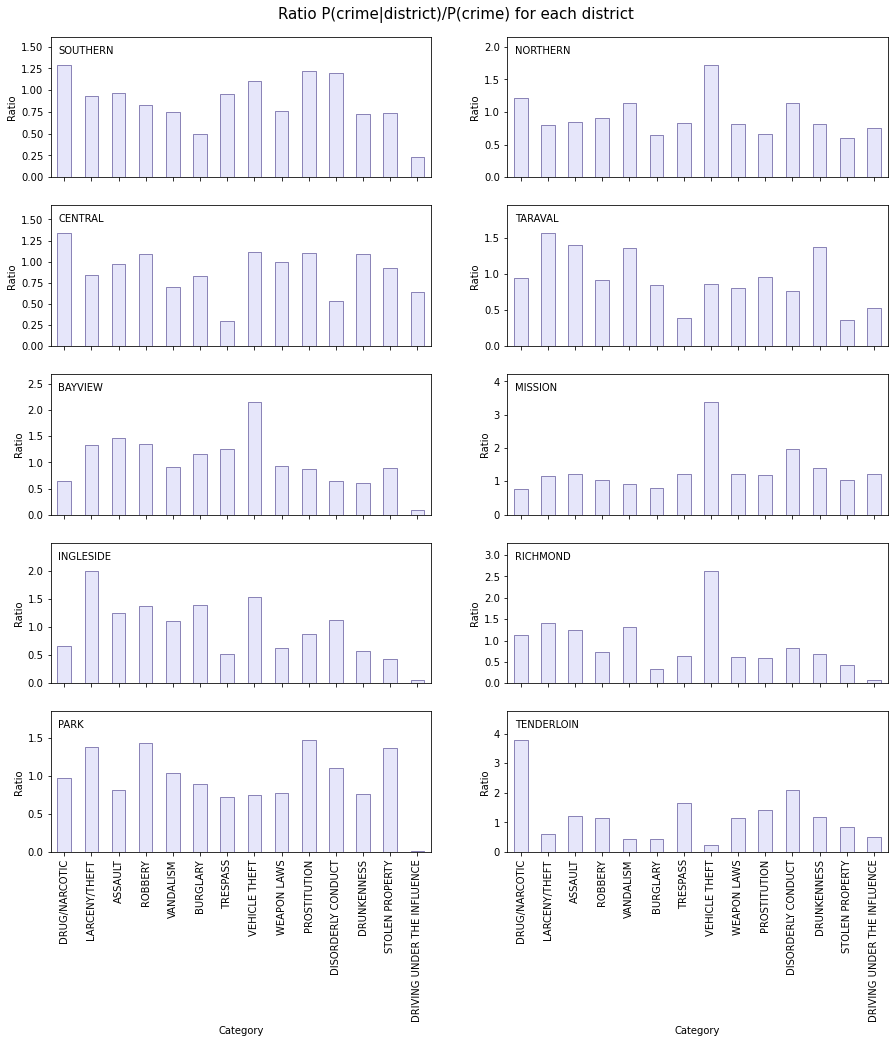

In [12]:
# plot the ratio for each district
nrows = int(len(dist[:-1])/2)
ncol = 2
fig, axes = plt.subplots(nrows, ncol,sharex=True, figsize =(15,15))

count = 0
for row in range(nrows):
    for col in range(ncol):
        district = list(dist[:-1])[count]
        ax = ratio_focus[district].plot(ax = axes[row, col], kind='bar', 
                                        color='lavender', edgecolor='darkslateblue', linewidth=0.6)
        ax.set_ylabel('Ratio')
          
        max_range = ratio_focus[district].max()
        ax.set_ylim([0, max_range+max_range/4])
        ax.text(0.02,0.88, district, transform=ax.transAxes)
        
        count += 1   
        
fig.text(0.5, 0.9, 'Ratio P(crime|district)/P(crime) for each district', ha='center', va='center', fontsize=15);

The figures show the ratio  $\frac{P(crime|district)}{P(crime)}$ for each district in the dataset. The ratio is equal to 1 if the crime occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the crime occurs more frequently within that district. If it's smaller than one, it means that the crime is rarer within the district in question than in the city as a whole.

According to the internet, Tenderloin has a bad repututation were drugs are often out in the open and garbage on the streets. This corresponds to the figure above, were the overall ratio is very high compared to other districts. In Tenderloin, drugs/narcotics have the highest ratio of all districts, with trespass and disorderly conduct being also significantly high.
[Ref: Tenderloin](https://www.kqed.org/news/11665527/why-hasnt-the-tenderloin-gentrified-like-the-rest-of-san-francisco)


When searching the web for Mission, we found out that it is one of the most dangerous places to live in San Francisco. When looking at the Mission figure above, it is clear to see that it has a very high ratio, especially for vehicle theft. [Ref: Mission](https://usaestaonline.com/how-safe-is-san-francisco?fbclid=IwAR13UltwuLiMz2g-UDvG0qbqzePYkL2lBrg_0UtNWWJKOx-TYGX1CbGoBM0)


Finally, the internet indicates that Richmond is a fairly safe district even though it has the same types of crimes that plague a lot of neighborhoods in San Francisco. Again, this corresponds to the figure above, were crimes in Richmond are at the same level as in the city as a whole, but have a fairly high ratio for vehicle theft.  [Ref: Richmond](https://www.richmondandtwickenhamtimes.co.uk/news/19325350.dangerous-areas-live-richmond/)

----

## Part 2: Fundamentals of data visualization

In the exercise below, there is a selection of questions from Week 3, Part 1. Please, check it out if you have any doubt on how to solve the exercise.

*Exercise:* 

* *Questions from the [lecture](https://www.youtube.com/watch?v=yiU56codNlI)*. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 
* *Hypothesis testing*. Use [data 1](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv) and [data 2](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv) to verify whether there is a statistically significant difference in the average number of steps taken by men and women. 
    * Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.
    * **Pretend you did not visualize the data yet.** What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was? 

> * Scatter plots. Create a scatter plot with both data samples by using *your own alternative* to color='#f6756d' and color='#10bdc3'. Explain why you chose this visualization, its pros, and cons.


## Part 3: Different types of visualization from DAOST


In [17]:
focus_df = data[data['Category'].isin(focuscrimes)]
focus_df['Date'] = pd.to_datetime(focus_df['Date'])
nr_of_crimes_per_day = focus_df.groupby(['Category', 'Date']).count()['PdId']

In [18]:
nr_of_crimes_per_day = nr_of_crimes_per_day.reset_index()

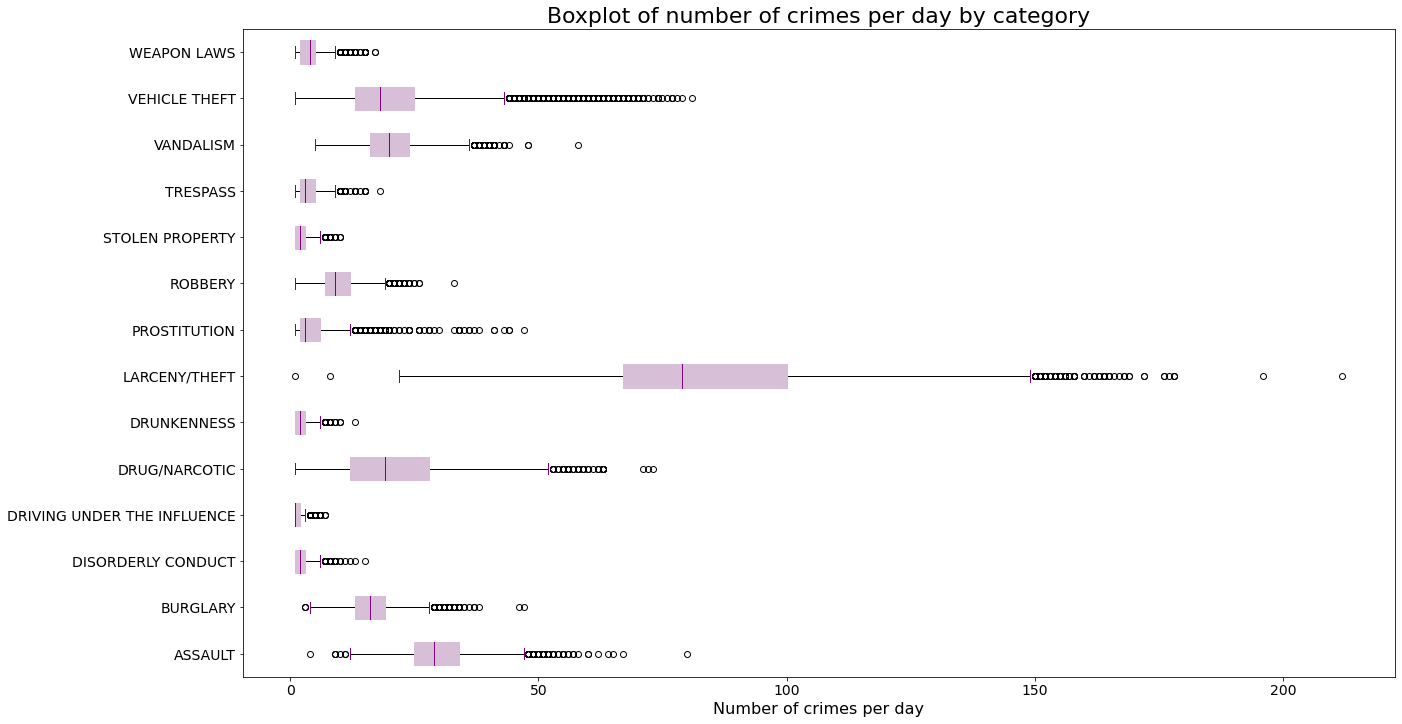

In [19]:
props = dict(boxes="thistle", whiskers="black", medians="purple", caps="purple")

boxp = nr_of_crimes_per_day.boxplot(
                    by='Category', 
                    column=['PdId'], 
                    figsize=(20, 12),
                    grid=False,
                    vert=False,
                    showfliers = True,
                    color=props, patch_artist=True)

# get rid of "boxplot grouped by" category
plt.suptitle("")

# label adjustment
p = plt.gca()
p.set_xlabel("Number of crimes per day", fontsize=16)
p.set_title("Boxplot of number of crimes per day by category", fontsize=22)
p.tick_params(axis='y', labelsize=14)
p.tick_params(axis='x', labelsize=14);

The plot above shows the number of crimes per day for each focus crime in the dataset. The purple line in the middle of the boxes indicates the mean of each foucs crime. From this plot it is again clear that larceny/theft is the most common crime in the dataset. Furthermore, from this we see that larceny/theft is also the most distributed crime. On the figure, we notice that there are some outliers (the black circles). For exampel, larceny/theft had over 200 crimes one day but around 0 crimes another day, which is both significantly far from the mean value. This is something that cannot be concluded from a simple bar chart.

In [20]:
focus_df['Time'] = pd.to_datetime(focus_df['Time'])
focus_df['Hour']= focus_df['Time'].dt.hour
focus_df['Minutes']= focus_df['Time'].dt.minute
focus_df['Time_fraction'] = focus_df['Hour'] + focus_df['Minutes'] / 60

In [21]:
weekdays = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':5 }
focus_df['Day_number'] = focus_df['DayOfWeek'].map(weekdays)

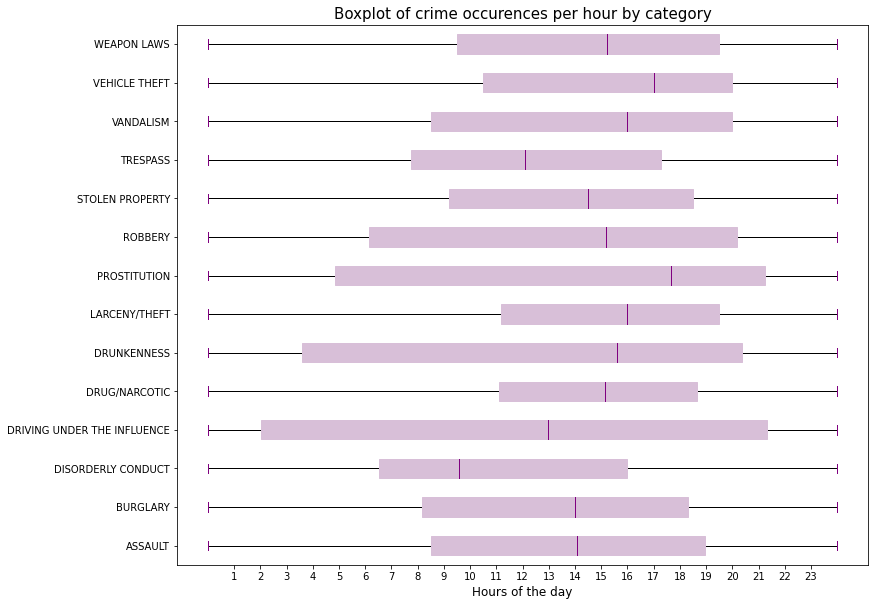

In [22]:
ticks = labels = [*range(1, 24, 1)]

props = dict(boxes="thistle", whiskers="black", medians="purple", caps="purple")

ax = focus_df.boxplot(
                    by='Category', 
                    column=['Time_fraction'], 
                    figsize=(12, 10),
                    grid=False,
                    vert=False,
                    showfliers = True,
                    color=props, 
                    patch_artist=True)
# get rid of "boxplot grouped by" title
plt.suptitle("")

# label adjustment
p = plt.gca()
p.set_xlabel("Hours of the day", fontsize=12)
p.set_title("Boxplot of crime occurences per hour by category", fontsize=15)
p.tick_params(axis='y', labelsize=10)
p.tick_params(axis='x', labelsize=10)

ax.set_xticks(ticks)
ax.set_xticklabels(labels);

The plot here shows the average time-of-day that a crime takes place. The boxes on this plot are fairly larger then on the plot made above. This shows that the time average plot is more distributed comepared to the boxplot above with the number of crimes per day. This is to be expected since crimes are more likely to happen troughout the day rather then happening at a specific timeslot each day. Therefore, there are no visible outliers on this plot, which is different from the former boxplot. 

-----

## Part 4 - Geospatial Analysis

In this section, we will analyze the crimes in the city of San Francisco and understand crime patterns in certain regions, because the functionality of the map is in HTML, it is necessary to run the cell to be able to visualize these patterns. In this example I searched the cases of prostitution to understand what are the regions in the city where this crime exists more and if along the years this has been changing.

### Heatmap

In [23]:
# choosing only one crime
df_map = focus_df.loc[focus_df['Category'] == 'PROSTITUTION']
df_map['datetime'] =df_map['Date'].dt.to_period('M')
df_map = df_map.sort_values(by="datetime")

In [24]:
# setting map
map_sf = folium.Map([37.77919, -122.41914], zoom_start=13)

In [25]:
# create count column and populate with 1 for grouping and summing
df_map['count'] = 1

# view latitude, longitude and count columns, groupby latitude and longitude summing up total for each xy coordinate
df2 = pd.DataFrame(
    df_map.groupby(['IncidntNum', 'Y', 'X'])\
    ['count'].sum().sort_values(ascending=False))

# create list of lat/long for input into folium HeatMap
lst = df2.groupby(
    ['Y', 'X'])\
    .sum().reset_index().values.tolist()

In [26]:
df_date_list = []
for date in df_map['datetime'].sort_values().unique(): 
    df_date_list.append(df_map.loc[df_map['datetime'] == date, # for each hour append to list  
    ['Y', 'X', 'count']]\
    .groupby(['Y', 'X'])\
    .sum().reset_index().values.tolist()) #sum totals per station, reset index and create list
    

In [27]:
# instantiate HeatMapWithTime
# creating a time index
time_index = []
for i in df_map['datetime'].unique():
    time_index.append(i)
    
# formatting the index
date_strings = [d.strftime('%Y-%m') for d in time_index]


HeatMapWithTime(df_date_list,radius=11,
                index = date_strings,
                gradient={0.1: 'blue', 0.5: 'lime', 0.7: 'orange', 1: 'red'}, 
                auto_play=True,
                min_opacity=0.4, 
                max_opacity=0.8, 
                use_local_extrema=True)\
                .add_to(map_sf);

In [28]:
map_sf

**1) What patterns does your movie reveal?**


The data selected were crimes reported as prostitution, we notice that there are two major clusters, one in the city center and one a little further away. Over the years the phenomenon started to occur, these clusters started to move away from their initial location. One hypothesis could be more frequent patrols in these regions and in order to get around the law new regions were created. 


**2) Motivate/explain the reasoning behind your choice of crimetype and time-resolution**

Analyzing the crimes of prostitution is intuitive to perform a geospatial exercise, as there are certain regions for this type of occurrence it is interesting to analyze what happens over time. The period selected was monthly, analyzing all the years because we would like to understand if this type of occurrence has remained in the same locations, where we can clearly see that it has not.


------

## Part 5: Errors in the data. 

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.
2. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.
3. And, during Week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

> *Exercise*: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below:
>
> * In each of the examples above, describe in your own words how the data-errors, I call attention to above, can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
> * Find your own example of human noise in the data and visualize it. Comment your results.

## Part 5 - Answers

### Example 1

In [29]:
prostitution_df = data[data['Category'] == 'PROSTITUTION']
prostitution_df['Weekday'] = prostitution_df['Date'].dt.dayofweek
prostitution_df['Time']= pd.to_datetime(prostitution_df['Time'])
prostitution_df['Hour']= prostitution_df['Time'].dt.hour 
prostitution_df['Minutes']=  prostitution_df['Time'].dt.minute
prostitution_df['15Minutes']= np.floor(prostitution_df['Minutes'] / 15)

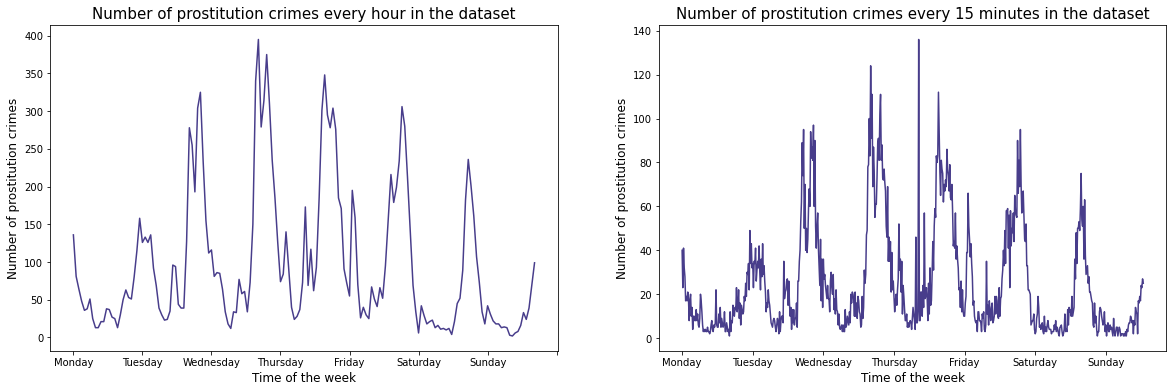

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 6))

# plot the number of prostitution crimes every hours
fig1 = prostitution_df.groupby(['Weekday','Hour']).count()\
                            ['PdId'].plot(color='darkslateblue', ax = axarr[0])

# plot the number of prostitution crimes every 15 minutes
fig2 = prostitution_df.groupby(['Weekday','Hour','15Minutes']).count()\
                            ['PdId'].plot(color='darkslateblue', ax = axarr[1])

fig1.set_title('Number of prostitution crimes every hour in the dataset', fontsize=15)
fig2.set_title('Number of prostitution crimes every 15 minutes in the dataset', fontsize=15)
fig1.set_ylabel('Number of prostitution crimes', fontsize=12)
fig2.set_ylabel('Number of prostitution crimes', fontsize=12)
fig1.set_xlabel('Time of the week', fontsize=12)
fig2.set_xlabel('Time of the week', fontsize=12)

fig1.axes.xaxis.set_ticklabels([])
fig2.axes.xaxis.set_ticklabels([])

day1_order = ['','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','','']
day2_order = ['','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','']
fig1.axes.xaxis.set_ticklabels(day1_order)
fig2.axes.xaxis.set_ticklabels(day2_order);

Here are the number of prostitution crimes plotted. The plot on the right shows how many prostitution crimes are committed every hour of the week and the plot on the left shows the prostitution of crimes every 15 minutes. This was done to be more precise and see more data points.

Now, a clear spike is in the middle of the figure to the left which was not captured on the figure to the right. We assume that this is an outlier since it is highly unlikely that the amount of prostitution crimes would be highest at 12.00 on Thursdays. This shows how important binning is since outliers can be missed.

### Example 2

In [31]:
start_date =  pd.to_datetime("01/01/2017", format='%m/%d/%Y')
end_date = pd.to_datetime("06/30/2017", format='%m/%d/%Y')

data['datetime'] = pd.to_datetime(data['Date'], format="%m/%d/%Y")
data = data[(data['datetime'] > start_date) & (data['datetime'] <= end_date)]

In [32]:
data['Time'] = pd.to_datetime(data['Time'])
data['Hour']= data['Time'].dt.hour
data['Minute']= data['Time'].dt.minute
data = data[(data['Hour'] >= 22) & (data['Hour'] <= 23)]

In [33]:
assault_df = data[data['Category'] == 'ASSAULT'].reset_index().drop('index', axis=1)

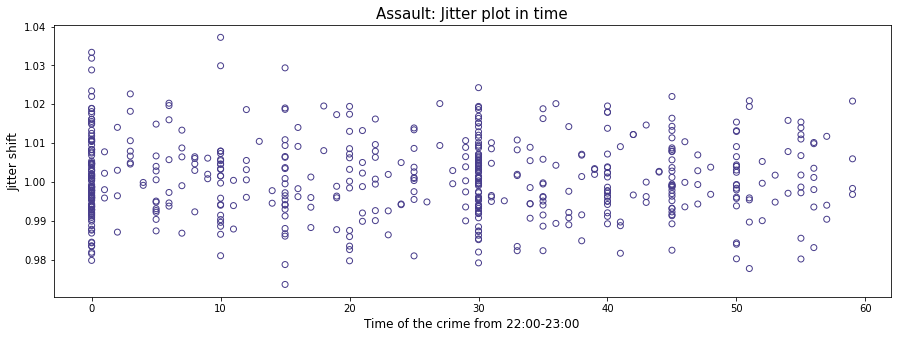

In [34]:
ya = np.random.randn(len(assault_df['Hour']))
y = np.random.normal(1, 0.01, len(ya))

plt.figure(figsize=(15,5))
plt.scatter(assault_df['Minute'], y, color = 'darkslateblue', marker='o',facecolors='none')
plt.xlabel('Time of the crime from 22:00-23:00', fontsize=12)
plt.ylabel('Jitter shift', fontsize=12)
plt.title('Assault: Jitter plot in time',fontsize=15);

The figure above shows jitters over 6 months of assault crimes happening from 22:00-23:00. Looking at what minute the crimes are happening it is clear to say that most of them are happening in the exact hour or half an hour. This may be due to rounding in time recording. It is very unlikely that criminals are only committing crimes on the exact hour or half an hour.

### Example 3

In [35]:
data = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

In [36]:
lon = -122.403670
lat = 37.775190

sf_map = folium.Map([lat, lon],
        tiles = "Stamen Toner",
           zoom_start=15)

# Ensure you're handing it floats
data['Y'] = data['Y'].astype(float)
data['X'] = data['X'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = data[data['Category'] == 'SEX OFFENSES, NON FORCIBLE']
heat_df = heat_df[['Y', 'X']]
heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Y'],row['X']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf_map)

# Marker
folium.Marker([37.775190, -122.403670], popup='Hall of Justice',icon=folium.Icon(color='orange', 
                                                        icon='institution', prefix='fa')).add_to(sf_map)

sf_map

The Hall of Justice is  located at this particulat point which is a courthouse and in week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. 

The reason why it seems that so many crimes are happening there could be that the crimes around this place are being reported there instead of at the actual location.

### Our example of human noise

In [37]:
focus_df['year'] = focus_df['Date'].dt.year

In [38]:
res = set(['ARREST, BOOKED', 'NONE', 'ARREST, CITED'])
res_df = focus_df[focus_df['Resolution'].isin(res)] # create a dataframe with res focus categories
res_df =  res_df.reset_index().drop('index', axis =1)
res_df = res_df[res_df['Date'].dt.year <= 2017]

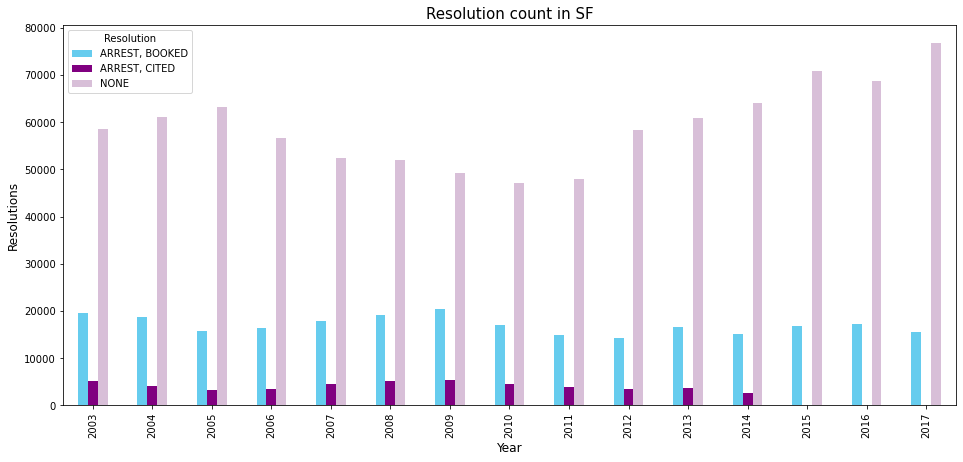

In [39]:
my_pivot = res_df.pivot_table(index = 'year',
                              columns = 'Resolution',
                              fill_value= 0,
                              aggfunc ={'Resolution':len})['Resolution']

chart = my_pivot.plot(kind='bar', linewidth=3.0, figsize=(16,7), color=['#66CCEE', 'purple', 'thistle'])

plt.title('Resolution count in SF', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Resolutions', fontsize=12);

We noticed a strange pattern in the resolution of crimes in San Francisco; for some reason, since 2014 the resolution classified as "arrested, cited" has dropped substantially for no apparent reason. One hypothesis could be that the recommendation not to use this resolution to classify crimes would increase the obvious idea of substitution (arrest, booked), but this did not happen. Instead, the resolution as None increased during the same period, we understand that this could be a human noise in the dataset, as a precise crime category was no longer used.

----

## References

1. “ACTIVITY INEQUALITY PROJECT". [Online]. Available:
http://activityinequality.stanford.edu/?fbclid=IwAR01b2LM9qVQE9WjvenfCtnGioNBGfJ0ArXkiM4poiL_yzbYpS6jHoGMlO0. [Accessed: Feb. 28, 2022].


2. "Is San Francisco Safe? Safety, Crime, Places to Avoid!". [Online]. Available:
https://usaestaonline.com/how-safe-is-san-francisco?fbclid=IwAR13UltwuLiMz2g-UDvG0qbqzePYkL2lBrg_0UtNWWJKOx-TYGX1CbGoBM0. [Accessed: Feb. 22, 2022].


3. “Most dangerous areas to live in Richmond" [Online]. Available: https://www.richmondandtwickenhamtimes.co.uk/news/19325350.dangerous-areas-live-richmond/. [Accessed: Feb. 22, 2022].


4. “Why Hasn't the Tenderloin Gentrified Like the Rest of San Francisco?". [Online]. Available:
https://www.kqed.org/news/11665527/why-hasnt-the-tenderloin-gentrified-like-the-rest-of-san-francisco. [Accessed: Feb. 22, 2022].
